# Crypto Market Making Bot for USD+/wETH and USD+/cbBTC

This notebook implements market making algorithms for Overnight.fi using Avellaneda-Stoikov methodology enhanced with Reinforcement Learning (RL).

In [1]:
# Import necessary libraries

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from datetime import datetime, timedelta

import sys
import os
import importlib.util



# Configure plotting

plt.style.use('ggplot')

%matplotlib inline



# Add project root to path

sys.path.append('..')

In [2]:
# Display system path to diagnose import issues
print("Python sys.path:")
for p in sys.path:
    print(f"  - {p}")

# Import the market_data module directly
import os
import importlib.util

# Use absolute path to the module
project_root = os.path.abspath('..')
market_data_path = os.path.join(project_root, 'src', 'utils', 'market_data.py')
print(f"\nLooking for market_data.py at: {market_data_path}")

if os.path.exists(market_data_path):
    print(f"✅ File exists")
    
    # Import the module using importlib
    spec = importlib.util.spec_from_file_location("market_data", market_data_path)
    market_data = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(market_data)
    
    # Get MarketDataHandler class from the module
    MarketDataHandler = getattr(market_data, 'MarketDataHandler')
    OnchainDataHandler = getattr(market_data, 'OnchainDataHandler')
    
    print(f"✅ Successfully imported MarketDataHandler: {MarketDataHandler}")
else:
    print(f"❌ File does not exist: {market_data_path}")

# Import other project modules directly
from src.models.avellaneda_stoikov import AvellanedaStoikovModel
from src.models.rl_enhanced_model import RLEnhancedModel
from src.backtesting.backtest_engine import BacktestEngine
from src.data.data_processor import DataProcessor

Python sys.path:
  - /opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python312.zip
  - /opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12
  - /opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload
  - 
  - /Users/nody/overnight/venv/lib/python3.12/site-packages
  - ..

Looking for market_data.py at: /Users/nody/overnight/src/utils/market_data.py
✅ File exists
✅ Successfully imported MarketDataHandler: <class 'market_data.MarketDataHandler'>


## 1. Generate Market Data

In [3]:
# Generate synthetic market data
data_processor = DataProcessor()

# Define date range
start_date = datetime.now() - timedelta(days=30)
end_date = datetime.now()
timestamps = pd.date_range(start=start_date, end=end_date, freq='1min')

# Generate price data
np.random.seed(42)
eth_price = 2000.0
btc_price = 50000.0

eth_prices = [eth_price]
btc_prices = [btc_price]

for _ in range(len(timestamps) - 1):
    eth_return = np.random.normal(0, 0.001)
    btc_return = np.random.normal(0, 0.001)
    
    eth_price *= (1 + eth_return)
    btc_price *= (1 + btc_return)
    
    eth_prices.append(eth_price)
    btc_prices.append(btc_price)

# Create DataFrames
eth_usdt_data = pd.DataFrame({
    'open': eth_prices,
    'high': [p * (1 + np.random.uniform(0, 0.002)) for p in eth_prices],
    'low': [p * (1 - np.random.uniform(0, 0.002)) for p in eth_prices],
    'close': eth_prices,
    'volume': np.random.uniform(10, 100, size=len(timestamps))
}, index=timestamps)

# Add technical features
eth_usdt_data = data_processor.add_technical_features(eth_usdt_data)

# Display data
eth_usdt_data.head()

/Users/nody/overnight/notebooks/../src/data/data_processor.py:284: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)


,open,high,low,close,volume,returns,volatility,mid_price,ma_20,ma_50,...,bb_std,bb_upper,bb_lower,ema_12,ema_26,macd,macd_signal,macd_hist,regime,trend
2025-04-02 19:07:26.094443,2000.000000,2000.889877,1997.898894,2000.000000,57.831989,0.000497,0.000885,1999.394385,1999.045404,1993.30163,...,3.593137,2006.231677,1991.85913,2000.000000,2000.000000,0.000000,0.000000,0.000000,low_vol,downtrend
2025-04-02 19:08:26.094443,2000.993428,2002.901288,2000.265304,2000.993428,93.294962,0.000497,0.000885,2001.583296,1999.045404,1993.30163,...,3.593137,2006.231677,1991.85913,2000.152835,2000.073587,0.079248,0.015850,0.063398,low_vol,downtrend
2025-04-02 19:09:26.094443,2002.289449,2002.588814,1998.573824,2002.289449,78.363657,0.000648,0.000885,2000.581319,1999.045404,1993.30163,...,3.593137,2006.231677,1991.85913,2000.481545,2000.237725,0.243820,0.061444,0.182376,low_vol,downtrend
2025-04-02 19:10:26.094443,2001.820606,2003.232567,1999.141468,2001.820606,25.952964,-0.000234,0.000885,2001.187018,1999.045404,1993.30163,...,3.593137,2006.231677,1991.85913,2000.687554,2000.354976,0.332579,0.115671,0.216908,low_vol,downtrend
2025-04-02 19:11:26.094443,2004.981907,2007.446361,2001.387294,2004.981907,25.096488,0.001579,0.000885,2004.416828,1999.045404,1993.30163,...,3.593137,2006.231677,1991.85913,2001.348224,2000.697711,0.650513,0.222639,0.427874,low_vol,downtrend


## 2. Implement Avellaneda-Stoikov Market Making Model

In [4]:
# Initialize the market making model
market_maker = AvellanedaStoikovModel(
    risk_aversion=1.0,  # Risk aversion parameter
    time_horizon=1.0,   # Time horizon in days
    volatility=eth_usdt_data['volatility'].mean()  # Use mean volatility from data
)

# Calculate quotes for a specific time
sample_time = eth_usdt_data.index[100]
sample_data = eth_usdt_data.loc[sample_time]
mid_price = sample_data['mid_price']

# Set model parameters
market_maker.set_parameters(volatility=sample_data['volatility'])
market_maker.update_inventory(0)  # Start with zero inventory

# Calculate optimal quotes
bid_price, ask_price = market_maker.calculate_optimal_quotes(mid_price)

print(f"Mid Price: ${mid_price:.2f}")
print(f"Bid Price: ${bid_price:.2f}")
print(f"Ask Price: ${ask_price:.2f}")
print(f"Spread: ${ask_price - bid_price:.2f} ({(ask_price - bid_price) / mid_price * 100:.4f}%)")

Mid Price: $1978.74
Bid Price: $1978.33
Ask Price: $1979.15
Spread: $0.81 (0.0410%)


## 3. Backtest the Market Making Strategy

In [5]:
# Initialize backtest engine
backtest_engine = BacktestEngine(
    market_data=eth_usdt_data,
    initial_capital=10000.0,
    transaction_fee=0.001
)

# Run backtest with the market making model
backtest_results = backtest_engine.run_backtest(
    model=market_maker,
    params={
        'risk_aversion': 1.0,
        'time_horizon': 1.0
    },
    max_inventory=50,
    volatility_window=20
)

# Display performance metrics
print("Performance Metrics:")
for key, value in backtest_results['metrics'].items():
    print(f"{key}: {value}")

2025-05-02 19:07:26,810 - src.backtesting.backtest_engine - INFO - Starting backtest with 43201 data points
/Users/nody/overnight/notebooks/../src/backtesting/backtest_engine.py:256: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1998.9889199949623' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  profitable_trades.at[i, 'buy_price'] = float(buy_trades.iloc[-1]['price'])
2025-05-02 19:09:06,232 - src.backtesting.backtest_engine - INFO - Backtest completed. Final PnL: -146787.13


Performance Metrics:
total_pnl: -146787.12924556763
realized_pnl: -176516.30433272035
unrealized_pnl: 29729.17508714599
max_drawdown: 146794.39890332863
max_inventory: 16
n_trades: 85145
sharpe_ratio: -0.003884696629695909
win_rate: 0.6300098670300239


## 4. Visualize Backtest Results

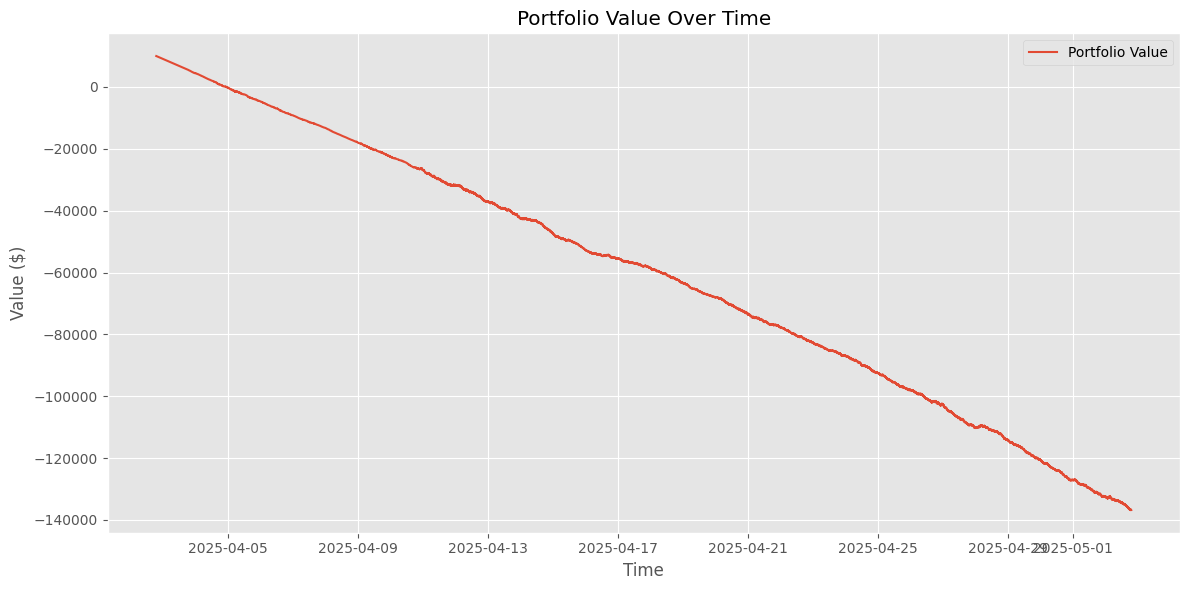

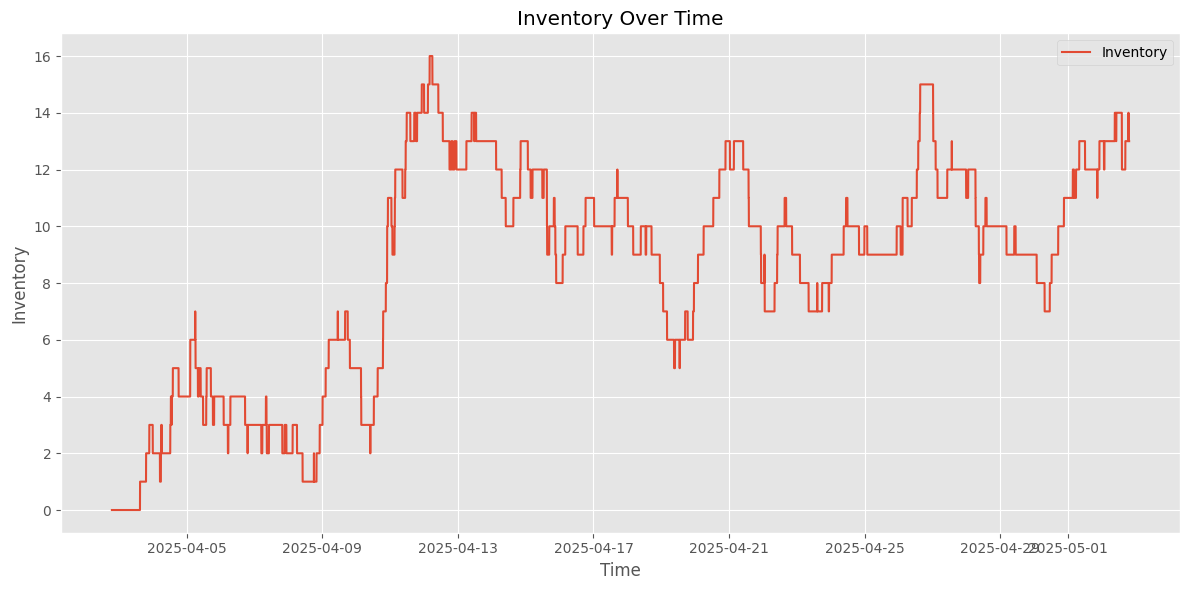

In [6]:
# Extract performance data
if backtest_results['positions'] is not None and not backtest_results['positions'].empty:
    performance_data = backtest_results['positions']
    
    # Plot equity curve
    plt.figure(figsize=(12, 6))
    plt.plot(performance_data['timestamp'], performance_data['total_value'], label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Time')
    plt.ylabel('Value ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot inventory
    plt.figure(figsize=(12, 6))
    plt.plot(performance_data['timestamp'], performance_data['inventory'], label='Inventory')
    plt.title('Inventory Over Time')
    plt.xlabel('Time')
    plt.ylabel('Inventory')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No position data available for plotting")

## 5. Enhance with Reinforcement Learning

In [7]:
# Initialize the RL-enhanced model
rl_model = RLEnhancedModel(base_model=market_maker)

# Run backtest with the enhanced model
rl_backtest_results = backtest_engine.run_backtest(
    model=rl_model,
    max_inventory=50,
    volatility_window=20
)

# Compare performance
if backtest_results['positions'] is not None and rl_backtest_results['positions'] is not None:
    base_performance = backtest_results['metrics']['total_pnl']
    rl_performance = rl_backtest_results['metrics']['total_pnl']
    
    print(f"Base Model PnL: ${base_performance:.2f}")
    print(f"RL-Enhanced Model PnL: ${rl_performance:.2f}")
    print(f"Improvement: {(rl_performance - base_performance) / abs(base_performance) * 100:.2f}%")
else:
    print("Insufficient data for comparison")

2025-05-02 19:09:06,519 - src.backtesting.backtest_engine - INFO - Starting backtest with 43201 data points
/Users/nody/overnight/notebooks/../src/backtesting/backtest_engine.py:256: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1998.9889199954146' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  profitable_trades.at[i, 'buy_price'] = float(buy_trades.iloc[-1]['price'])
2025-05-02 19:10:45,610 - src.backtesting.backtest_engine - INFO - Backtest completed. Final PnL: -146841.41


Base Model PnL: $-146787.13
RL-Enhanced Model PnL: $-146841.41
Improvement: -0.04%
